In [11]:
#!/usr/bin/env python
# coding: utf-8
# !pip install mediapy
import torch
from diffusers import StableDiffusionXLPipeline,DDIMScheduler, AutoencoderKL, UNet2DConditionModel
from PIL import Image
#from ip_adapter_bp import myIPAdapterXL
from ip_adapter import DDCA
# load ip-adapter
import glob
import wandb
from tqdm import tqdm
from ip_adapter.utils import register_cross_attention_hook, get_net_attn_map, attnmaps2images
import pandas as pd
import mediapy
import random
import pandas as pd



sdxl_model_path = "/hy-tmp/models/stable-diffusion-xl-base-1.0"
image_encoder_path = "/hy-tmp/models/IP-Adapter/models/image_encoder"

# sdxl_model_path = "/dfs/comicai/zhiyuan.shi/models/SG161222/RealVisXL_V3.0"
# image_encoder_path = "/dfs/comicai/zhengbing.yao/models/IP-Adapter/models/image_encoder/"

device = "cuda:0"
dtype = torch.float32


In [12]:

pipe = StableDiffusionXLPipeline.from_pretrained(
    #real_model_path,
    sdxl_model_path,
    torch_dtype=dtype,
#     unet=unet,
    use_safetensors= True,
    #
    #scheduler=noise_scheduler,
    safety_checker=None,
    add_watermarker=False,
)


#pipe.unet = register_cross_attention_hook(pipe.unet)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.22it/s]


In [13]:
# infer_image_paths = glob.glob("/dfs/comicai/zhengbing.yao/datasets/1_ez_1031_2k/faces/*")
# image_paths = glob.glob("infer_images/faces/*")
data = pd.read_csv("/hy-tmp/datasts/data.csv")
image_paths = data["image_path"].to_list()
prompts = data["prompt"].to_list()
# image_paths = 

In [14]:
import copy
!nvidia-smi

Wed Oct  9 13:08:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   40C    P0    35W / 250W |  37563MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Token indices sequence length is longer than the specified maximum sequence length for this model (145 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["a mesmerizing portrayal of this iconic bird. each stitch is expertly placed to emphasize the peacock's regal pose and proud demeanor, making it a striking addition to any project. whether adorning a garment, accessory, or home décor item, this exquisite embroidery design is sure to captivate and inspire all who behold it."]
Token indices sequence length is longer than the specified maximum sequence length for this model (145 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["a mesmerizing portrayal of this iconic bird. each stitch is expertly placed to emphasize the peacock's

The next embroidery design in this collection features a graceful peacock, meticulously embroidered with dazzling threads that shimmer with iridescent colors. The peacock's majestic feathers are intricately stitched to capture their intricate patterns and vibrant hues, creating a stunning visual display that symbolizes beauty and elegance. The embroidery style seamlessly blends traditional craftsmanship with a contemporary flair, resulting in a mesmerizing portrayal of this iconic bird. Each stitch is expertly placed to emphasize the peacock's regal pose and proud demeanor, making it a striking addition to any project. Whether adorning a garment, accessory, or home décor item, this exquisite embroidery design is sure to captivate and inspire all who behold it.



100%|██████████| 50/50 [00:10<00:00,  4.91it/s]



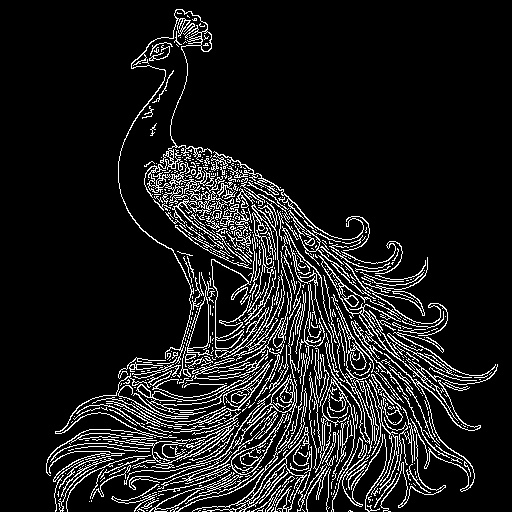
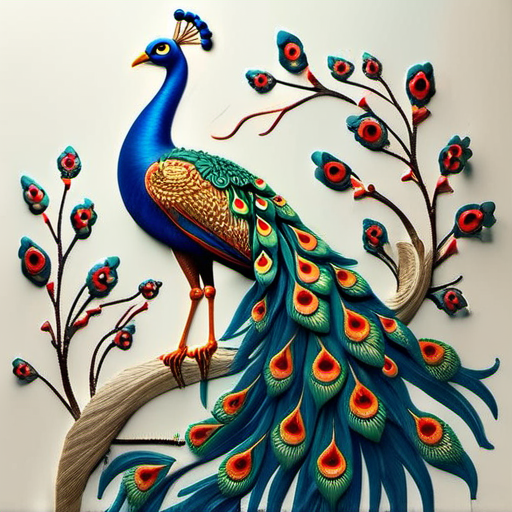

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["and vibrant interpretation of floral motifs. every stitch is placed with precision to capture the essence of each flower's form and texture, making the design both charming and visually captivating. whether embellishing clothing, accessories, or home décor items, this enchanting embroidery design exudes a sense of joy and positivity, celebrating the beauty and wonder of the natural world."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["and vibrant interpretation of floral motifs. every stitch is placed with precision to capture the essence of each flower's form and texture, making the design both charming and visually captivating. whether embellishing clothing, accessories, or home décor items, this enchanting embroidery design exudes a sense of joy and positivity, celebrating the beauty and wonder of the natural world."]


Another exquisite embroidery design in this collection depicts a whimsical array of blooming flowers, intricately stitched with a rich palette of colors and fine detailing. Each flower is meticulously crafted to showcase its unique beauty and delicate petals, bringing a touch of nature's elegance into any project. The embroidery style expertly combines traditional techniques with a modern sensibility, creating a fresh and vibrant interpretation of floral motifs. Every stitch is placed with precision to capture the essence of each flower's form and texture, making the design both charming and visually captivating. Whether embellishing clothing, accessories, or home décor items, this enchanting embroidery design exudes a sense of joy and positivity, celebrating the beauty and wonder of the natural world.



100%|██████████| 50/50 [00:10<00:00,  4.88it/s]



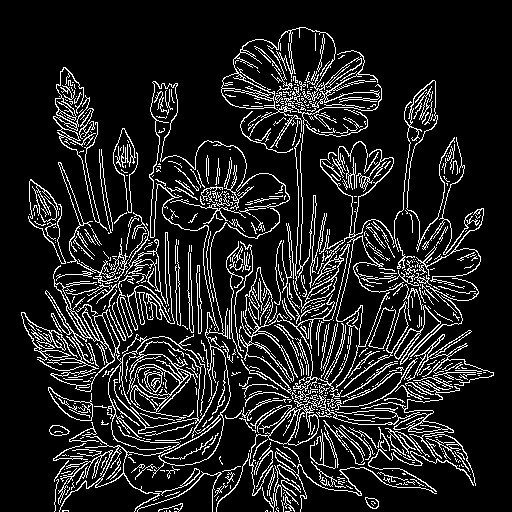
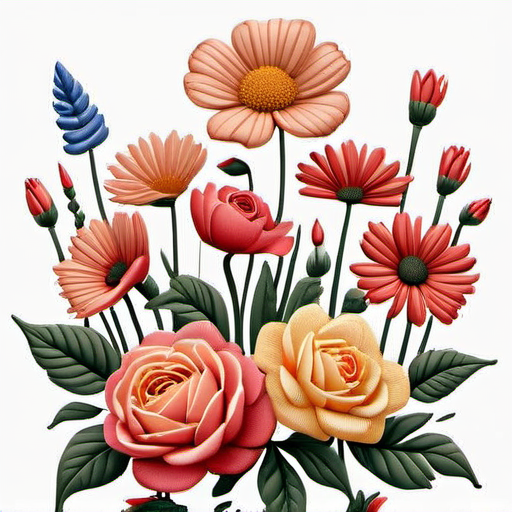

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["and powerful portrayal of this iconic creature. each stitch is placed with care to highlight the lion's strength and majesty, creating a striking and impactful image. whether adorning clothing, accessories, or home décor items, this dramatic embroidery design commands attention and admiration, showcasing the beauty and power of the animal kingdom. this intricate embroidery design features a graceful peacock, its feathers shimmering with brilliant hues as if caught in a dance of colors. the skilled stitching captures the majestic beauty of the bird, from its elegant posture to the intricate patterns adorning its plumage. the embroidery style effortlessly blends traditional techniques with a contemporary flair, resulting in a stunning portrayal of nature's splendor. each stitch is delicately placed to showcase the peacock's regal demeanor and intricate details, making the design a tru

A captivating embroidery design in this collection features a majestic lion, intricately stitched with a combination of bold colors and intricate detailing. The lion's mane is carefully embroidered to capture its impressive volume and texture, while its piercing eyes and noble expression bring the animal's regal presence to life. The embroidery style seamlessly blends traditional techniques with a contemporary aesthetic, resulting in a dynamic and powerful portrayal of this iconic creature. Each stitch is placed with care to highlight the lion's strength and majesty, creating a striking and impactful image. Whether adorning clothing, accessories, or home décor items, this dramatic embroidery design commands attention and admiration, showcasing the beauty and power of the animal kingdom.This intricate embroidery design features a graceful peacock, its feathers shimmering with brilliant hues as if caught in a dance of colors. The skilled stitching captures the majestic beauty of the bird

100%|██████████| 50/50 [00:10<00:00,  4.87it/s]



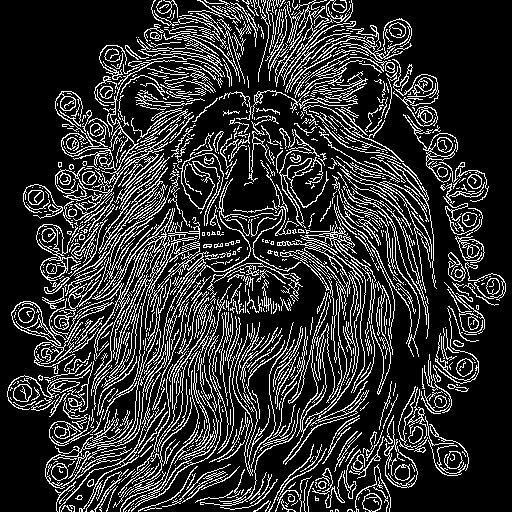
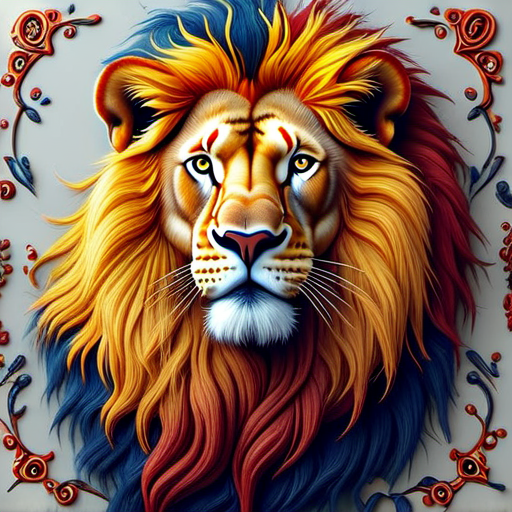

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["carefully placed to capture the squirrel's fluffy fur, bright eyes, and lively expression, making the design both endearing and visually captivating. the use of vibrant colors and fine details showcases the squirrel's delightful features, making it a perfect embellishment for clothing, accessories, or home decor items. this unique embroidery style celebrates the beauty and whimsy of nature, turning ordinary fabric into a magical work of art."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["carefully placed to capture the squirrel's fluffy fur, bright eyes, and lively expression, making the design both endearing and visually captivating. the use of vibrant colors and fine details showcases the squirrel's delightful features, making it a perfect embellishment for clothing, accessories, or home decor items. this unique embroider

In this enchanting embroidery design, a whimsical forest scene comes to life through delicate stitches and intricate detailing. Amongst the lush foliage and blooming flowers, a mischievous squirrel scampers about, its tail curled in a playful arc. The embroidery style seamlessly blends traditional techniques with a modern twist, creating a charming and vibrant portrayal of the woodland creature. Each stitch is carefully placed to capture the squirrel's fluffy fur, bright eyes, and lively expression, making the design both endearing and visually captivating. The use of vibrant colors and fine details showcases the squirrel's delightful features, making it a perfect embellishment for clothing, accessories, or home decor items. This unique embroidery style celebrates the beauty and whimsy of nature, turning ordinary fabric into a magical work of art.



100%|██████████| 50/50 [00:10<00:00,  4.86it/s]



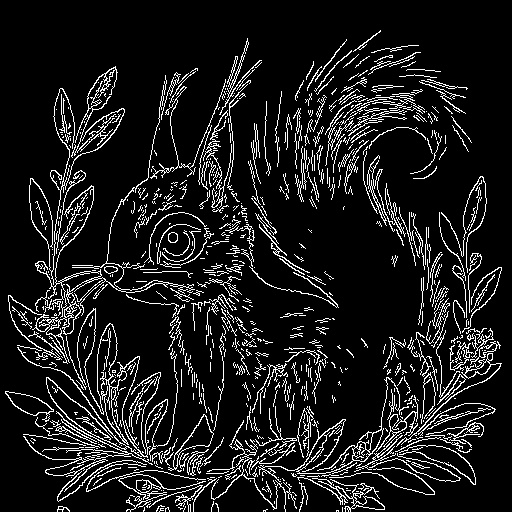
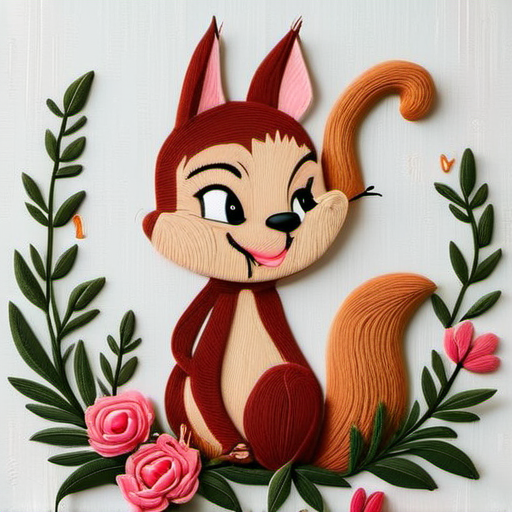

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["in a striking portrayal of this iconic animal. each stitch is carefully placed to showcase the lion's noble features and fierce expression, making the design both captivating and awe - inspiring. the use of rich colors and fine detailing highlights the lion's majestic presence, making it a stunning addition to any fabric or decor piece. this unique embroidery style celebrates the beauty and power of the lion, transforming simple fabric into a truly magnificent work of art."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["in a striking portrayal of this iconic animal. each stitch is carefully placed to showcase the lion's noble features and fierce expression, making the design both captivating and awe - inspiring. the use of rich colors and fine detailing highlights the lion's majestic presence, making it a stunning addition t

This exquisite embroidery design showcases a majestic lion, its mane flowing like fiery threads of silk as it gazes into the distance with regal poise. The intricate stitching captures the power and strength of the king of the jungle, from its piercing gaze to the intricate details of its fur and whiskers. The embroidery style seamlessly blends traditional techniques with a modern sensibility, resulting in a striking portrayal of this iconic animal. Each stitch is carefully placed to showcase the lion's noble features and fierce expression, making the design both captivating and awe-inspiring. The use of rich colors and fine detailing highlights the lion's majestic presence, making it a stunning addition to any fabric or decor piece. This unique embroidery style celebrates the beauty and power of the lion, transforming simple fabric into a truly magnificent work of art.



100%|██████████| 50/50 [00:10<00:00,  4.85it/s]



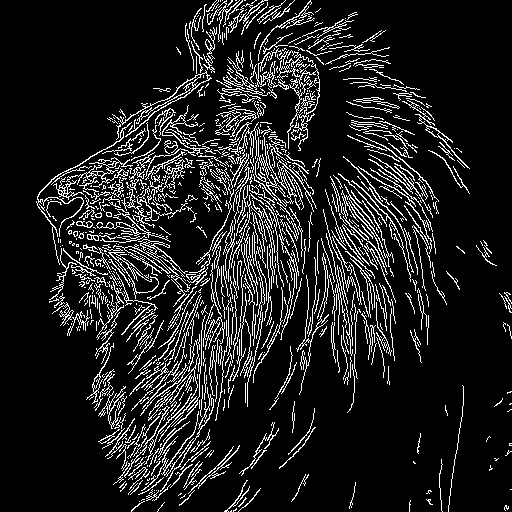
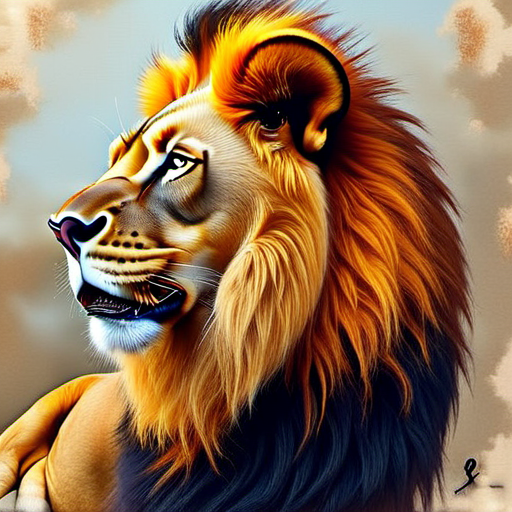

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['to the design, making it a perfect embellishment for any garment or home décor piece.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['to the design, making it a perfect embellishment for any garment or home décor piece.']


This intricate embroidery design features a graceful peacock, meticulously stitched with intricate patterns and vibrant colors to highlight its majestic beauty. The delicate threads bring out the elegant details of the peacock's feathers and regal posture, creating a stunning and enchanting portrayal of this magnificent bird. The combination of traditional embroidery techniques with a contemporary flair adds a touch of sophistication to the design, making it a perfect embellishment for any garment or home décor piece.



100%|██████████| 50/50 [00:10<00:00,  4.84it/s]



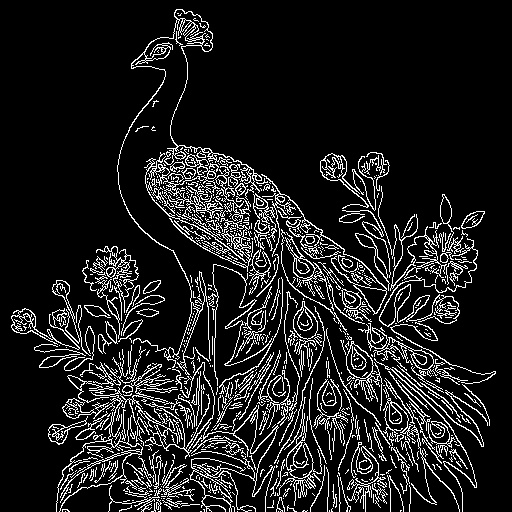
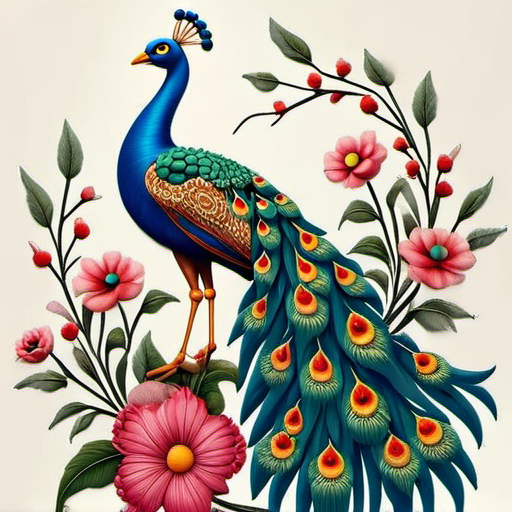

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['creating a unique and eye - catching piece that is sure to turn heads wherever it is displayed.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['creating a unique and eye - catching piece that is sure to turn heads wherever it is displayed.']


Immerse yourself in the enchanting world of nature with this stunning embroidery design of a graceful butterfly, delicately stitched with fine threads to showcase its intricate wings and delicate features. The careful placement of each stitch captures the beauty and grace of the butterfly, making it a captivating and mesmerizing embellishment. The use of vibrant colors and intricate detailing adds a modern twist to the traditional embroidery style, creating a unique and eye-catching piece that is sure to turn heads wherever it is displayed.



100%|██████████| 50/50 [00:10<00:00,  4.84it/s]



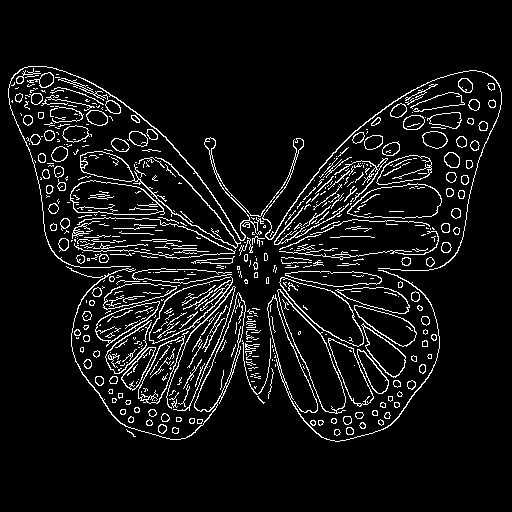
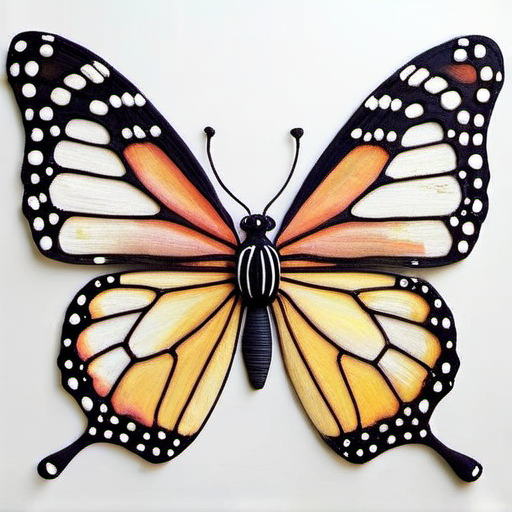

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["and patterns of the deer's antlers and fur, making it a perfect embellishment for clothing, accessories, or home décor items. celebrate the beauty and grace of nature with this exquisite embroidery design that brings the serene and magical forest to life."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["and patterns of the deer's antlers and fur, making it a perfect embellishment for clothing, accessories, or home décor items. celebrate the beauty and grace of nature with this exquisite embroidery design that brings the serene and magical forest to life."]


Dive into the mystical realm of the forest with this captivating embroidery design of a majestic deer, intricately stitched with fine threads to bring out its noble presence and gentle nature. The traditional embroidery techniques used in this design are enhanced with a touch of modern flair, creating a mesmerizing and enchanting portrayal of the deer. The use of rich colors and intricate details highlight the graceful curves and patterns of the deer's antlers and fur, making it a perfect embellishment for clothing, accessories, or home décor items. Celebrate the beauty and grace of nature with this exquisite embroidery design that brings the serene and magical forest to life.



100%|██████████| 50/50 [00:10<00:00,  4.83it/s]



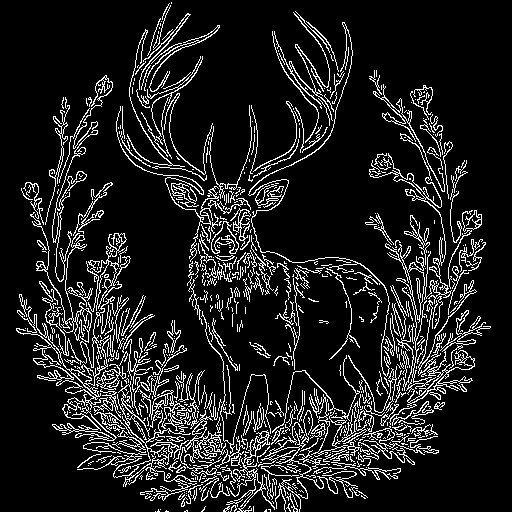
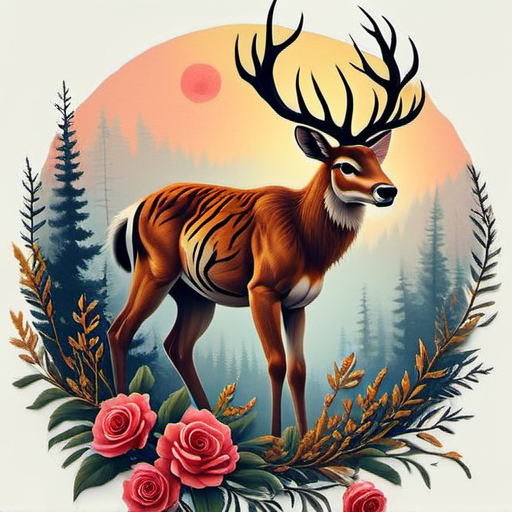

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['portrayal that will enhance any fabric or garment with a touch of opulence.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['portrayal that will enhance any fabric or garment with a touch of opulence.']


This exquisite embroidery design features a graceful peacock, its stunning plumage meticulously crafted with intricate stitches that shimmer and shine with iridescent beauty. Each feather is brought to life with a blend of vibrant colors and fine detailing that captures the elegance and majesty of this regal bird. The peacock's proud stance and captivating gaze are delicately embroidered to create a mesmerizing portrayal that will enhance any fabric or garment with a touch of opulence.



100%|██████████| 50/50 [00:10<00:00,  4.83it/s]



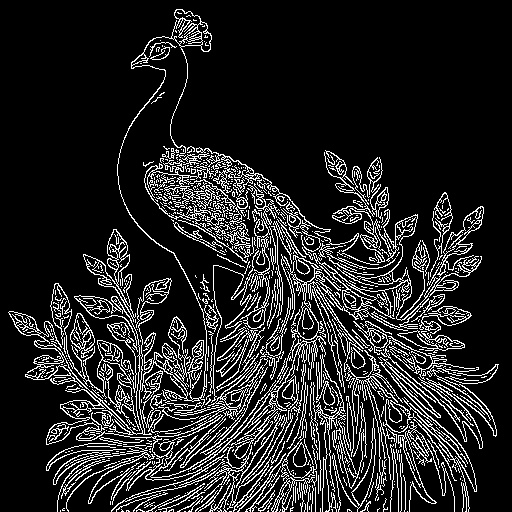
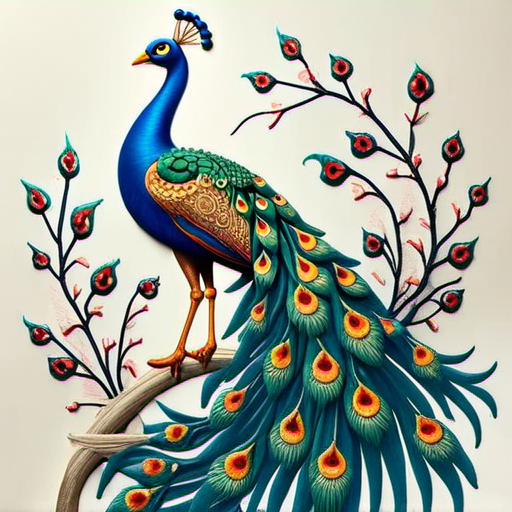

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['creating a dynamic and visually striking motif that evokes ancient tales of heroism and adventure.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['creating a dynamic and visually striking motif that evokes ancient tales of heroism and adventure.']


In this enchanting embroidery design, a majestic dragon unfurls its serpentine body amidst swirling clouds and fiery motifs, its fierce visage embroidered with exquisite detail that captures the mythical creature's legendary power and grandeur. The dragon's scales gleam with metallic threads, while its fiery breath is depicted in a blaze of rich, vibrant colors that dance across the fabric, creating a dynamic and visually striking motif that evokes ancient tales of heroism and adventure.



100%|██████████| 50/50 [00:10<00:00,  4.82it/s]



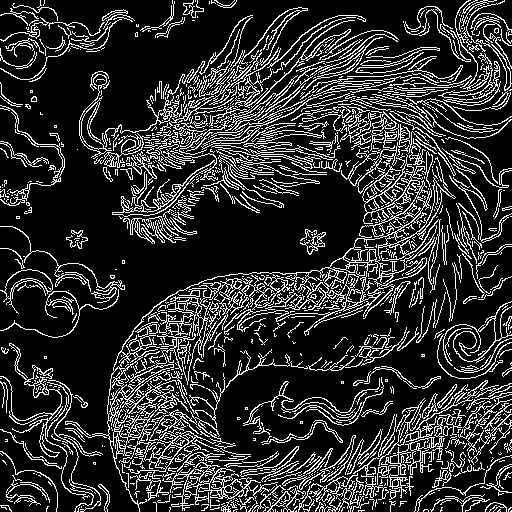
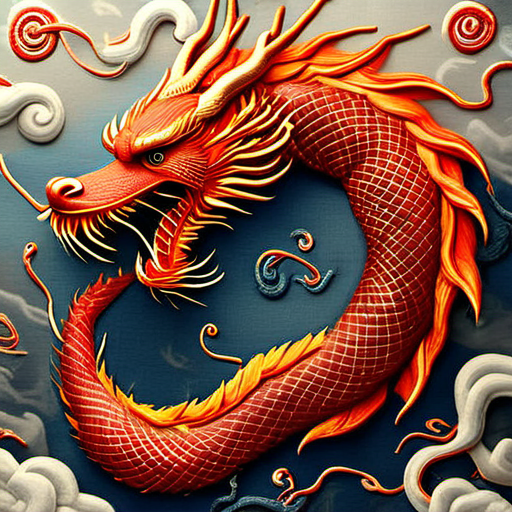

In [22]:
import copy
import glob
import numpy as np

# def padding(image):
#     w, h = image.size
#     max_edge = max(w, h)
#     image = np.array(image)
#     ph, pw = max_edge - h, max_edge - w
#     new_image = np.ones([max_edge, max_edge, 3], dtype=np.uint8) * 0
#     new_image[ph // 2:ph // 2 + h, pw // 2:pw // 2 + w,:] = image

#     image = Image.fromarray(new_image)
#     return image
sd_pipe = copy.deepcopy(pipe)
    
ip_ckpt = "YZBPXX/CCDA/model.pth"
ip_ckpt = "/hy-tmp/models/my-ipadapter/exp1/checkpoint-46000/model.pth"
opt = {
    # "select_token":[0,4,5,8,9],
    "only_text":False,
    "only_image":False,
    "only_text_left_image":False,

}
ip_model = DDCA(sd_pipe, 
              image_encoder_path,
              ip_ckpt,
#                                   ip_ckpt+"/model.pth", 
              device, 
              scale=1, 
              dtype=dtype,
              num_tokens=16,
              opt=opt
             )


for i, image_path in enumerate(image_paths[:10]):


    
    # face = padding(image)
    image_path = "/hy-tmp/datasts/" + image_path
    # prompt = prompts[0]
    ip_image_path = image_path.replace("images", "process_images")
    image = Image.open(ip_image_path).convert("RGB")
    # prompts = [
    #     "a old man is reading a book in classroom, full body",
    #     "a old man is is dancing on the beach, full body",
    #     "a old man are walking in garden, full body",
    # ] 
    prompt_images = []
    for prompt in prompts[i:i+1]:
        print(prompt)
        tokens = ip_model.pipe.tokenizer.encode(prompt)
        tokens = [pipe.tokenizer.decode(token) for token in tokens]

        width = 512
        height = 512
        images = ip_model.generate(
                        pil_image=image,
                        prompt=prompt,
                        negative_prompt="",
                        num_samples=1,                                                                                                                                                                                                                                                                 
                        num_inference_steps=50,
                        width=width, height=height,
                        seed=2023)
    
        prompt_images.append(images[0])
        
    mediapy.show_images([image]+prompt_images)
#         attn_map = get_net_attn_map((height, width))
#         attn_hot = attnmaps2images(attn_map, images[0])
#         mediapy.show_images(attn_hot)
#         attn_maps = get_net_attn_map((height, width))
#         for attn_map in attn_maps:
#             attn_hot = attnmaps2images(attn_map)
#             mediapy.show_images(attn_hot)

del ip_model.pipe
del ip_model
del sd_pipe
